In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
import time

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows)))
        for j, row in enumerate(rows):
            
            indices = range(rows[j] - lookback, rows[j], step)
   
            samples[j] = data[indices]
    
            targets[j] = data[rows[j] + delay]
        
        yield samples, targets

In [78]:
df_ITS_perday = pd.read_excel(r"C:\Users\1\Desktop\Papka\Прогнозирование ИТС\Full_dataset_transformer.xlsx")
df_ITS_perday=df_ITS_perday[['ИТС']]
# df_ITS_perday=df_ITS_perday.set_index('Data')
display(df_ITS_perday)

,ИТС
0,100.0
1,100.0
2,100.0
3,100.0
4,100.0
...,...
9737,100.0
9738,100.0
9739,100.0
9740,100.0


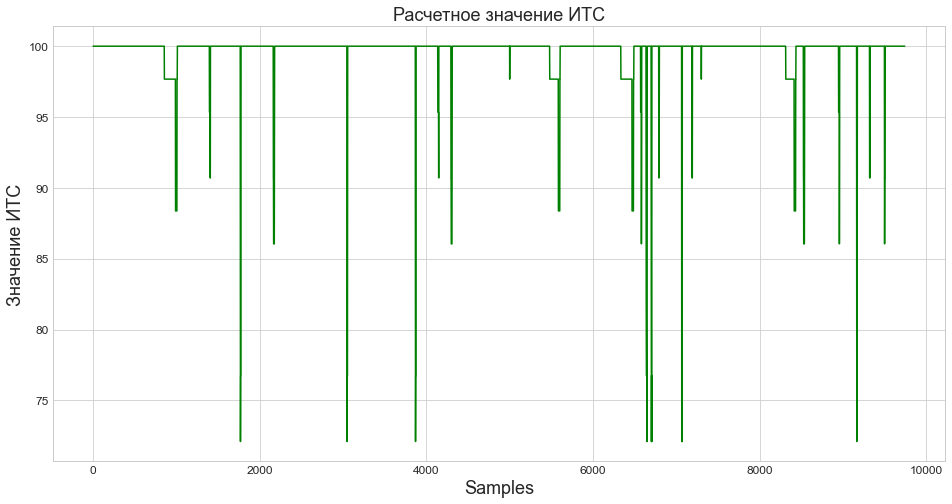

In [79]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(df_ITS_perday, 'g')
plt.title('Расчетное значение ИТС', fontsize=18)
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Значение ИТС', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [80]:
# Сначала необходимо разделить данные на 3 части (выборки): обучающую, валидационную и тестовую
data_train, data_test = train_test_split(df_ITS_perday, test_size=0.36, random_state=42, shuffle = False)
data_train, data_valid = train_test_split(data_train, test_size=0.33, random_state=42, shuffle = False)

display(data_train)
display(data_test)
display(data_valid)

scaler = MinMaxScaler()
scaler.fit(data_train)

data_train_sc = scaler.transform(data_train)
data_valid_sc = scaler.transform(data_valid)
data_test_sc = scaler.transform(data_test)

,ИТС
0,100.0
1,100.0
2,100.0
3,100.0
4,100.0
...,...
4171,100.0
4172,100.0
4173,100.0
4174,100.0


,ИТС
6234,100.0
6235,100.0
6236,100.0
6237,100.0
6238,100.0
...,...
9737,100.0
9738,100.0
9739,100.0
9740,100.0


,ИТС
4176,100.0
4177,100.0
4178,100.0
4179,100.0
4180,100.0
...,...
6229,100.0
6230,100.0
6231,100.0
6232,100.0


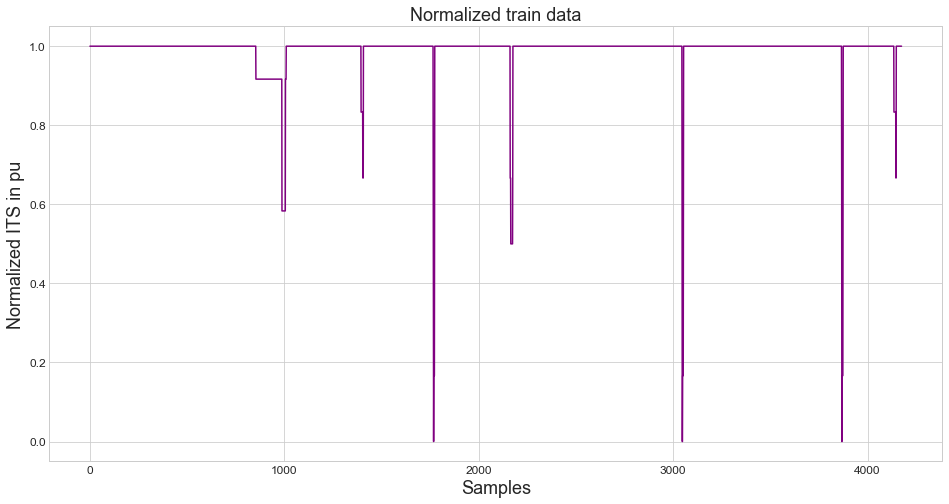

In [81]:
plt.figure(figsize=(16, 8))
plt.plot(data_train_sc, 'purple')
plt.title('Normalized train data', fontsize=18)
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Normalized ITS in pu', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

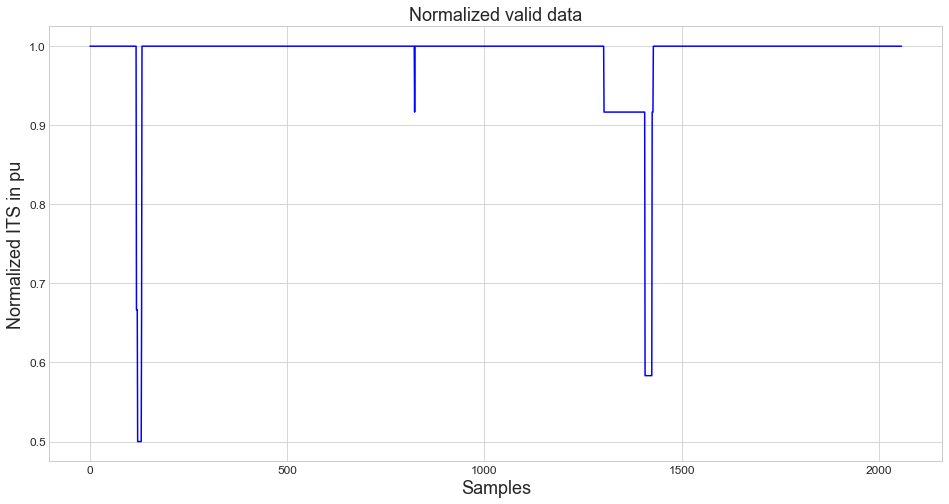

In [82]:
plt.figure(figsize=(16, 8))
plt.plot(data_valid_sc, 'blue')
plt.title('Normalized valid data', fontsize=18)
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Normalized ITS in pu', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

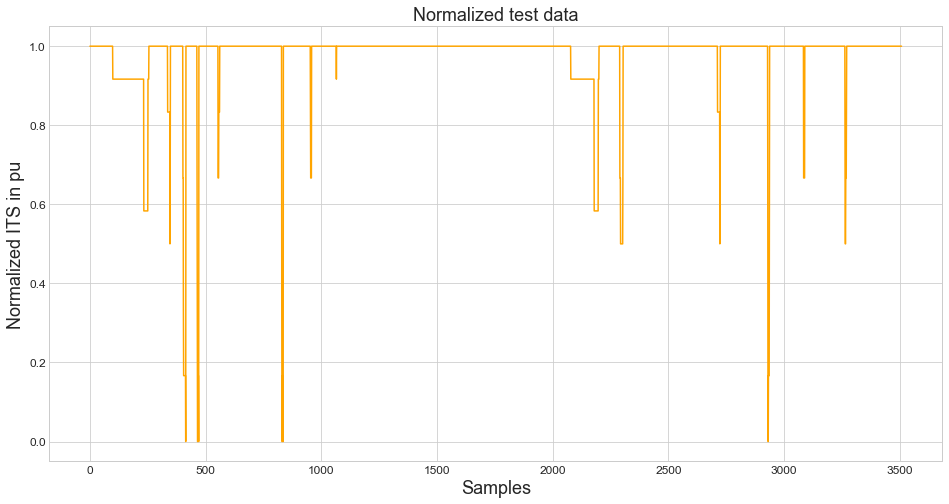

In [83]:
plt.figure(figsize=(16, 8))
plt.plot(data_test_sc, 'orange')
plt.title('Normalized test data', fontsize=18)
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Normalized ITS in pu', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [84]:
lookback=30
step=1
delay=1
batch_size=128

train_generator = generator(data_train_sc, 
                            lookback=lookback, 
                            delay=delay, 
                            min_index=0, 
                            max_index=data_train_sc.size, 
                            shuffle=False, 
                            batch_size=batch_size, 
                            step=step)
valid_generator = generator(data_valid_sc, 
                            lookback=lookback, 
                            delay=delay,
                            min_index=0, 
                            max_index=data_valid_sc.size, 
                            shuffle=False,  
                            batch_size=batch_size,
                            step=step)
test_generator = generator(data_test_sc, 
                           lookback=lookback,
                           delay=delay,
                           min_index=0,
                           max_index=data_test_sc.size, 
                           shuffle=False, 
                           batch_size=batch_size,
                           step=step)

In [85]:
# Запускаем генератор один раз и получаем из него выборки (признаки) и целевые значения
samples, targets = next(test_generator)
# Если повторно запускать генератор, то будут выдаваться новые значения
samples_range = np.arange(0, samples.shape[0], 1)
# Выборки имеют форму (размер пакета, размер окна с признаками, признаки)
pred = samples[:,-1,0]
r_squared = r2_score(y_true=targets, y_pred=pred)
mae = mean_absolute_error(y_true=targets, y_pred=pred)
r_squared_error = 'Коэффициент детерминации без привлечения МО - {}'\
.format(r_squared)
print(r_squared_error)
mean_abs_error = 'Средняя абсолютная ошибка для решения без привлечения МО - {}'\
.format(mae)
print(mean_abs_error)

Коэффициент детерминации без привлечения МО - 0.9372549019607843
Средняя абсолютная ошибка для решения без привлечения МО - 0.0013020833333333426


In [86]:
samples.shape[0]

128

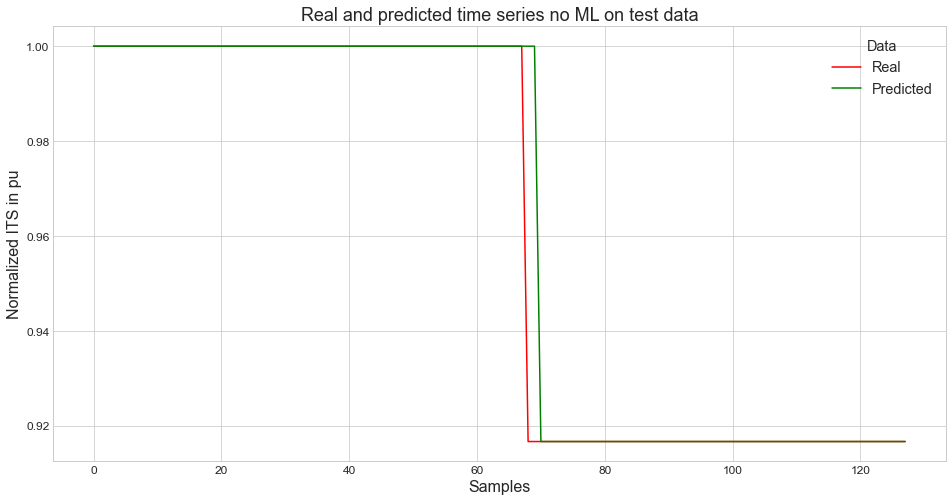

In [87]:
# Визуализируем спрогнозированного и фактического временных рядов на одном графике
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('Real and predicted time series no ML on test data', fontsize=18)
ax1.plot(samples_range, targets[0:samples.shape[0]], 'r', label = 'Real')
ax1.plot(samples_range, pred, 'g', label = 'Predicted')
ax1.set_xlabel('Samples', fontsize=16)
ax1.set_ylabel('Normalized ITS in pu', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Обучение рекуррентной сети для прогнозирования временного ряда (GRU). Расчет коэффициента детерминации и средней абсолютной ошибки. Визуализация спрогнозированных и фактических временных рядов на одном графике.

In [21]:
# Создаем модель нейронной сети
model = Sequential()
# Слой рекуррентной нейронной сети
model.add(GRU(32, return_sequences = True, input_shape = (None, data_train_sc.shape[-1])))
# Добавляем второй слой рекуррентной нейронной сети
model.add(GRU(32, activation = 'relu'))
# Выходной полносвязанный слой
model.add(Dense(1))
# Статистика с архитектурой сети
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 32)          3360      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Задаем макисмальное число эпох
EPOCHS = 20
# Создаем пустые списки для метрик качества
r_squared_list_train_rnn2l = []
r_squared_list_valid_rnn2l = []
epochs_range = np.arange(1, EPOCHS+1, 1)
start = time.time()
model.compile(loss='mse', 
              optimizer = 'adam',
              metrics=[r2_score],
              run_eagerly=True)
history = model.fit(train_generator, steps_per_epoch=100, epochs = EPOCHS,
                    verbose = 0, validation_data = valid_generator, validation_steps=1)
# Обучаем модель Recurrent neural network (2 rec layers)
for epochs_val in epochs_range:
    r_squared_list_train_rnn2l.append(history.history['r2_score'][epochs_val-1])
    r_squared_list_valid_rnn2l.append(history.history['val_r2_score'][epochs_val-1])

stop = time.time()
result = 'Время работы модели Recurrent neural network (2 rec layers) - {} секунд'\
.format(stop - start)
# Сводим значения метрик в таблицу
matrix = np.matrix(np.c_[epochs_range, r_squared_list_train_rnn2l, r_squared_list_valid_rnn2l]) 
df_models = pd.DataFrame(data=matrix, columns=['n_epochs', 'train_r_squared', 'valid_r_squared'])
# Определяем наибольшее значение r_squared
best_r_squared = df_models['valid_r_squared'].max()
# Определяем индекс соответствующий наибольшему значению r_squared
best_index = df_models['valid_r_squared'].idxmax()
max_r_squared_rnn2l = 'Наибольшее значение r_squared алгоритма Recurrent neural network (2 rec layers) для валидационной выборки - {}'\
.format(best_r_squared)
optimum_n_epochs = 'Оптимальное значение числа эпох для модели Recurrent neural network (2 rec layers) - {}'\
.format(epochs_range[best_index])
print(result)
print(max_r_squared_rnn2l)
print(optimum_n_epochs)

Время работы модели Recurrent neural network (2 rec layers) - 393.7451708316803 секунд
Наибольшее значение r_squared алгоритма Recurrent neural network (2 rec layers) для валидационной выборки - 0.7045738697052002
Оптимальное значение числа эпох для модели Recurrent neural network (2 rec layers) - 16


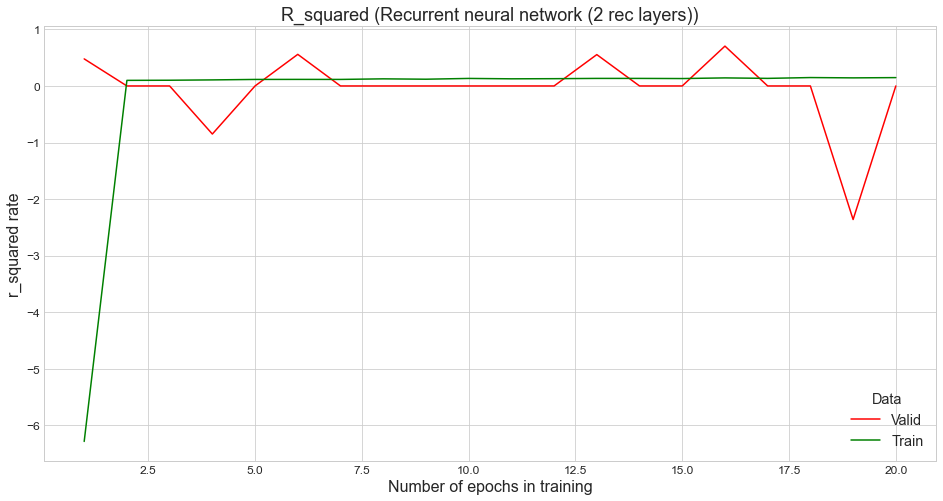

In [23]:
# Визуализируем метрики r_squared для Recurrent neural network (2 rec layers) для тренировочной и валидационной выборки
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('R_squared (Recurrent neural network (2 rec layers))', fontsize=18)
ax1.plot(epochs_range, r_squared_list_valid_rnn2l, 'r', label = 'Valid')
ax1.plot(epochs_range, r_squared_list_train_rnn2l, 'g', label = 'Train')
ax1.set_xlabel('Number of epochs in training', fontsize=16)
ax1.set_ylabel('r_squared rate', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [24]:
# По найденному оптимальному параметру обучаем новый классификатор по Recurrent neural network (2 rec layers)
model.fit(train_generator, steps_per_epoch=100, epochs=epochs_range[best_index],
          verbose=0, validation_data=test_generator, validation_steps=1, initial_epoch=epochs_range[best_index-1])

In [25]:
# Проверяем итоговое качество модели Recurrent neural network (2 rec layers) на тестовых данных
samples, targets = next(test_generator)
pred = model.predict(samples)
r_squared = r2_score(y_true=targets, y_pred=pred)
mae = mean_absolute_error(y_true=targets, y_pred=pred)
r_squared_error = 'Коэффициент детерминации для решения с Recurrent neural network (2 rec layers) - {}'\
.format(r_squared)
print(r_squared_error)
mean_abs_error = 'Средняя абсолютная ошибка для решения с Recurrent neural network (2 rec layers) - {}'\
.format(mae)
print(mean_abs_error)

4/4 [==============================] - 0s 70ms/step
Коэффициент детерминации для решения с Recurrent neural network (2 rec layers) - 0.49533902336942803
Средняя абсолютная ошибка для решения с Recurrent neural network (2 rec layers) - 0.04719854204449802


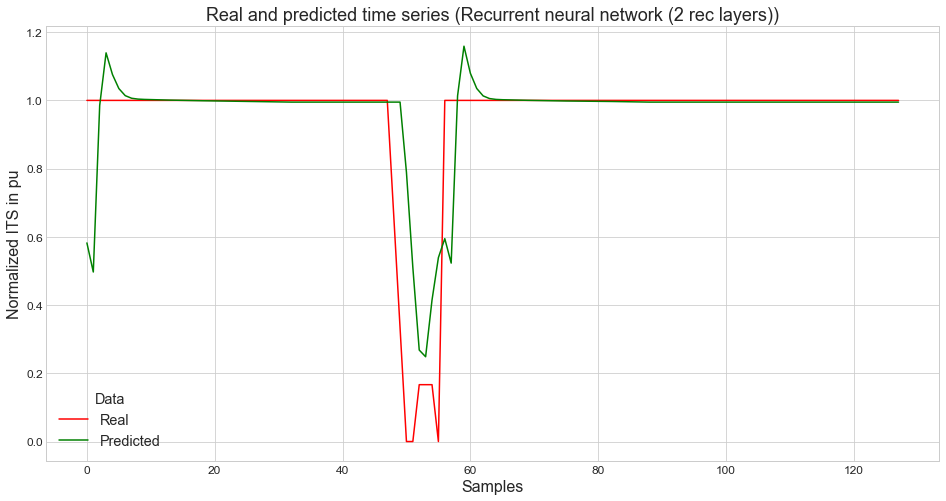

In [26]:
# Визуализируем спрогнозированного и фактического временных рядов на одном графике
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('Real and predicted time series (Recurrent neural network (2 rec layers))', fontsize=18)
ax1.plot(samples_range, targets[0:samples.shape[0]], 'r', label = 'Real')
ax1.plot(samples_range, pred, 'g', label = 'Predicted')
ax1.set_xlabel('Samples', fontsize=16)
ax1.set_ylabel('Normalized ITS in pu', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Обучение рекуррентной сети для прогнозирования временного ряда (LSTM). Расчет коэффициента детерминации и средней абсолютной ошибки. Визуализация спрогнозированных и фактических временных рядов на одном графике.

In [38]:
model = Sequential()
model.add(LSTM(32, return_sequences = True, input_shape = (None, data_train_sc.shape[-1])))
model.add(LSTM(32, activation = 'relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Задаем макисмальное число эпох
EPOCHS = 20
# Создаем пустые списки для метрик качества
r_squared_list_train_rnn2lstm = []
r_squared_list_valid_rnn2lstm = []
epochs_range = np.arange(1, EPOCHS+1, 1)
start = time.time()
model.compile(loss='mse', 
              optimizer = 'adam',
              metrics=[r2_score],
              run_eagerly=True)
history = model.fit(train_generator, steps_per_epoch=100, epochs = EPOCHS,
                    verbose = 0, validation_data = valid_generator, validation_steps=1)

for epochs_val in epochs_range:
    r_squared_list_train_rnn2lstm.append(history.history['r2_score'][epochs_val-1])
    r_squared_list_valid_rnn2lstm.append(history.history['val_r2_score'][epochs_val-1])

stop = time.time()
result = 'Время работы модели Recurrent neural network (2 rec layers, LSTM) - {} секунд'\
.format(stop - start)
# Сводим значения метрик в таблицу
matrix = np.matrix(np.c_[epochs_range, r_squared_list_train_rnn2lstm, r_squared_list_valid_rnn2lstm]) 
df_models = pd.DataFrame(data=matrix, columns=['n_epochs', 'train_r_squared', 'valid_r_squared'])
# Определяем наибольшее значение r_squared
best_r_squared = df_models['valid_r_squared'].max()
# Определяем индекс соответствующий наибольшему значению r_squared
best_index = df_models['valid_r_squared'].idxmax()
max_r_squared_rnn2lstm = 'Наибольшее значение r_squared алгоритма Recurrent neural network (2 rec layers, LSTM) для валидационной выборки - {}'\
.format(best_r_squared)
optimum_n_epochs = 'Оптимальное значение числа эпох для модели Recurrent neural network (2 rec layers, LSTM) - {}'\
.format(epochs_range[best_index])
print(result)
print(max_r_squared_rnn2lstm)
print(optimum_n_epochs)

Время работы модели Recurrent neural network (2 rec layers, LSTM) - 328.59288811683655 секунд
Наибольшее значение r_squared алгоритма Recurrent neural network (2 rec layers, LSTM) для валидационной выборки - 0.7539756894111633
Оптимальное значение числа эпох для модели Recurrent neural network (2 rec layers, LSTM) - 16


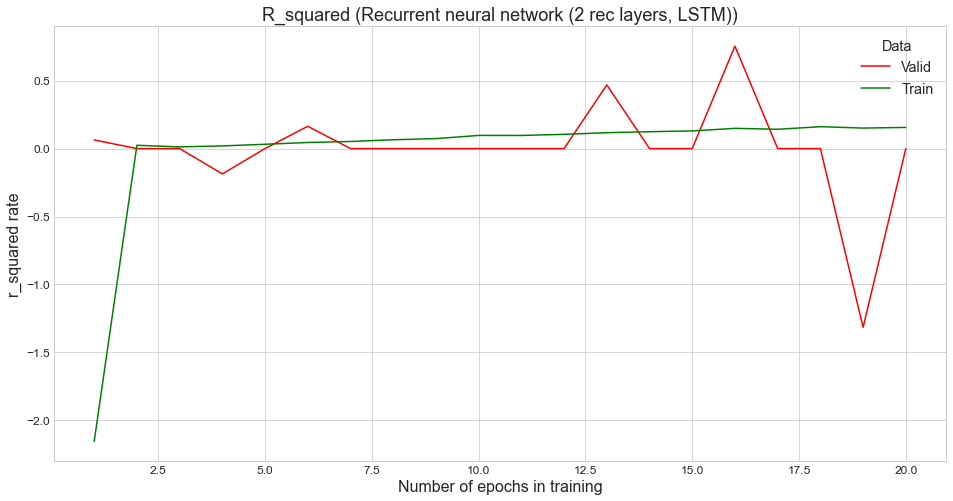

In [40]:
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('R_squared (Recurrent neural network (2 rec layers, LSTM))', fontsize=18)
ax1.plot(epochs_range, r_squared_list_valid_rnn2lstm, 'r', label = 'Valid')
ax1.plot(epochs_range, r_squared_list_train_rnn2lstm, 'g', label = 'Train')
ax1.set_xlabel('Number of epochs in training', fontsize=16)
ax1.set_ylabel('r_squared rate', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [41]:
# По найденному оптимальному параметру обучаем новый классификатор по Recurrent neural network (2 rec layers, LSTM)
model.fit(train_generator, steps_per_epoch=100, epochs=epochs_range[best_index],
          verbose=0, validation_data=test_generator, validation_steps=1, initial_epoch=epochs_range[best_index-1])

In [42]:
# Проверяем итоговое качество модели Recurrent neural network (2 rec layers, LSTM) на тестовых данных
samples, targets = next(test_generator)
pred = model.predict(samples)
r_squared = r2_score(y_true=targets, y_pred=pred)
mae = mean_absolute_error(y_true=targets, y_pred=pred)
r_squared_error = 'Коэффициент детерминации для решения с Recurrent neural network (2 rec layers, LSTM) - {}'\
.format(r_squared)
print(r_squared_error)
mean_abs_error = 'Средняя абсолютная ошибка для решения с Recurrent neural network (2 rec layers, LSTM) - {}'\
.format(mae)
print(mean_abs_error)

4/4 [==============================] - 0s 58ms/step
Коэффициент детерминации для решения с Recurrent neural network (2 rec layers, LSTM) - 0.5284273080384809
Средняя абсолютная ошибка для решения с Recurrent neural network (2 rec layers, LSTM) - 0.0544229323665301


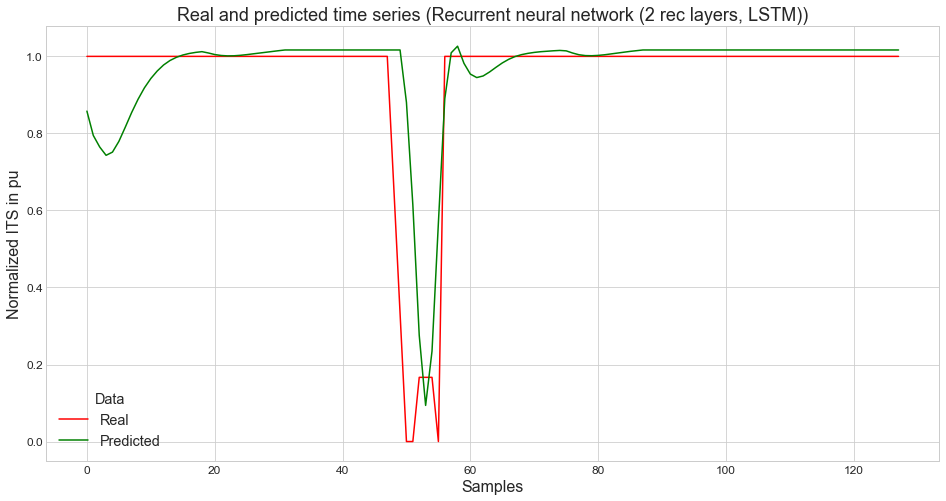

In [43]:
# Визуализируем спрогнозированного и фактического временных рядов на одном графике
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('Real and predicted time series (Recurrent neural network (2 rec layers, LSTM))', fontsize=18)
ax1.plot(samples_range, targets[0:samples.shape[0]], 'r', label = 'Real')
ax1.plot(samples_range, pred, 'g', label = 'Predicted')
ax1.set_xlabel('Samples', fontsize=16)
ax1.set_ylabel('Normalized ITS in pu', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Обучение рекуррентной сети для прогнозирования временного ряда (GRU) с прореживанием. Расчет коэффициента детерминации и средней абсолютной ошибки. Визуализация спрогнозированных и фактических временных рядов на одном графике.

In [88]:
model = Sequential()
model.add(GRU(32, dropout = 0.1, recurrent_dropout = 0.5, return_sequences = True,
              input_shape = (None, data_train_sc.shape[-1])))
model.add(GRU(32, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.5))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, None, 32)          3360      
                                                                 
 gru_6 (GRU)                 (None, 32)                6336      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [89]:
EPOCHS = 20

r_squared_list_train_rnn2ldo = []
r_squared_list_valid_rnn2ldo = []
epochs_range = np.arange(1, EPOCHS+1, 1)
start = time.time()
model.compile(loss='mse', 
              optimizer = 'adam',
              metrics=[r2_score],
              run_eagerly=True)
history = model.fit(train_generator, steps_per_epoch=100, epochs = EPOCHS,
                    verbose = 0, validation_data = valid_generator, validation_steps=1)
# Обучаем модель Recurrent neural network (2 rec layers)
for epochs_val in epochs_range:
    r_squared_list_train_rnn2ldo.append(history.history['r2_score'][epochs_val-1])
    r_squared_list_valid_rnn2ldo.append(history.history['val_r2_score'][epochs_val-1])

stop = time.time()
result = 'Время работы модели Recurrent neural network (2 rec layers+do) - {} секунд'\
.format(stop - start)
# Сводим значения метрик в таблицу
matrix = np.matrix(np.c_[epochs_range, r_squared_list_train_rnn2ldo, r_squared_list_valid_rnn2ldo]) 
df_models = pd.DataFrame(data=matrix, columns=['n_epochs', 'train_r_squared', 'valid_r_squared'])
# Определяем наибольшее значение r_squared
best_r_squared = df_models['valid_r_squared'].max()
# Определяем индекс соответствующий наибольшему значению r_squared
best_index = df_models['valid_r_squared'].idxmax()
max_r_squared_rnn2ldo = 'Наибольшее значение r_squared алгоритма Recurrent neural network (2 rec layers+do) для валидационной выборки - {}'\
.format(best_r_squared)
optimum_n_epochs = 'Оптимальное значение числа эпох для модели Recurrent neural network (2 rec layers+do) - {}'\
.format(epochs_range[best_index])
print(result)
print(max_r_squared_rnn2ldo)
print(optimum_n_epochs)

Время работы модели Recurrent neural network (2 rec layers+do) - 1275.5436997413635 секунд
Наибольшее значение r_squared алгоритма Recurrent neural network (2 rec layers+do) для валидационной выборки - 0.46164965629577637
Оптимальное значение числа эпох для модели Recurrent neural network (2 rec layers+do) - 16


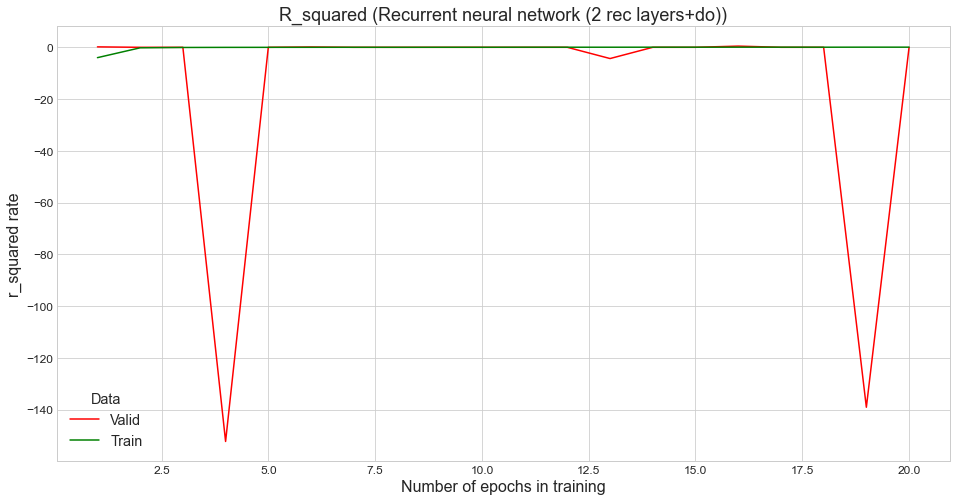

In [90]:
# Визуализируем метрики r_squared для Recurrent neural network (2 rec layers+do) для тренировочной и валидационной выборки
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('R_squared (Recurrent neural network (2 rec layers+do))', fontsize=18)
ax1.plot(epochs_range, r_squared_list_valid_rnn2ldo, 'r', label = 'Valid')
ax1.plot(epochs_range, r_squared_list_train_rnn2ldo, 'g', label = 'Train')
ax1.set_xlabel('Number of epochs in training', fontsize=16)
ax1.set_ylabel('r_squared rate', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [91]:
# По найденному оптимальному параметру обучаем новый классификатор по Recurrent neural network (2 rec layers+do)
model.fit(train_generator, steps_per_epoch=100, epochs=epochs_range[best_index],
          verbose=0, validation_data=test_generator, validation_steps=1, initial_epoch=epochs_range[best_index-1])

In [92]:
# Проверяем итоговое качество модели Recurrent neural network (2 rec layers+do) на тестовых данных
samples, targets = next(test_generator)
pred = model.predict(samples)
r_squared = r2_score(y_true=targets, y_pred=pred)
mae = mean_absolute_error(y_true=targets, y_pred=pred)
r_squared_error = 'Коэффициент детерминации для решения с Recurrent neural network (2 rec layers+do) - {}'\
.format(r_squared)
print(r_squared_error)
mean_abs_error = 'Средняя абсолютная ошибка для решения с Recurrent neural network (2 rec layers+do) - {}'\
.format(mae)
print(mean_abs_error)

4/4 [==============================] - 1s 275ms/step
Коэффициент детерминации для решения с Recurrent neural network (2 rec layers+do) - 0.42469268954740114
Средняя абсолютная ошибка для решения с Recurrent neural network (2 rec layers+do) - 0.08229228481650352


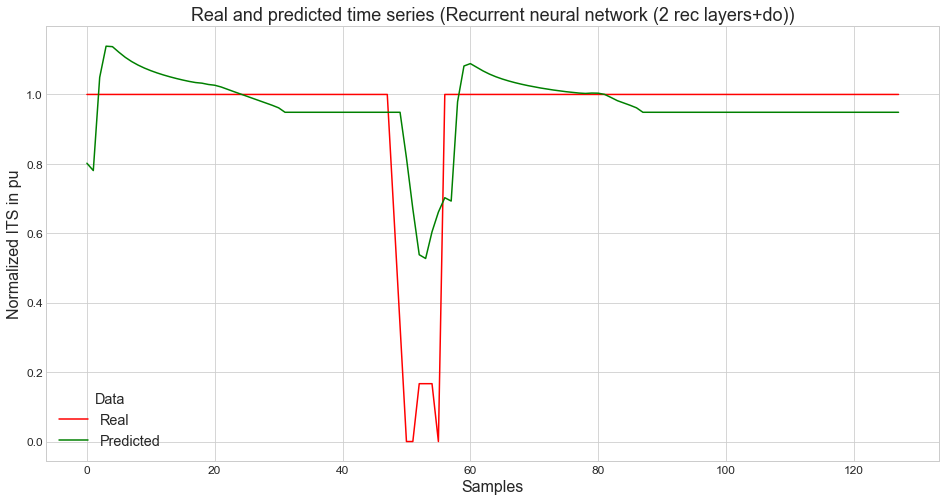

In [93]:
# Визуализируем спрогнозированного и фактического временных рядов на одном графике
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('Real and predicted time series (Recurrent neural network (2 rec layers+do))', fontsize=18)
ax1.plot(samples_range, targets[0:samples.shape[0]], 'r', label = 'Real')
ax1.plot(samples_range, pred, 'g', label = 'Predicted')
ax1.set_xlabel('Samples', fontsize=16)
ax1.set_ylabel('Normalized ITS in pu', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Обучение рекуррентной сети для прогнозирования временного ряда (LSTM) с тремя слоями. Расчет коэффициента детерминации и средней абсолютной ошибки. Визуализация спрогнозированных и фактических временных рядов на одном графике.

In [55]:
model = Sequential()
model.add(LSTM(32, return_sequences = True, input_shape = (None, data_train_sc.shape[-1])))
model.add(LSTM(32, return_sequences = True, activation = 'relu'))
model.add(LSTM(32, activation = 'relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 32)          4352      
                                                                 
 lstm_3 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [56]:
EPOCHS = 20

r_squared_list_train_rnn3l = []
r_squared_list_valid_rnn3l = []
epochs_range = np.arange(1, EPOCHS+1, 1)
start = time.time()
model.compile(loss='mse', 
              optimizer = 'adam',
              metrics=[r2_score],
              run_eagerly=True)
history = model.fit(train_generator, steps_per_epoch=100, epochs = EPOCHS,
                    verbose = 0, validation_data = valid_generator, validation_steps=1)
# Обучаем модель Recurrent neural network (3 rec layers)
for epochs_val in epochs_range:
    r_squared_list_train_rnn3l.append(history.history['r2_score'][epochs_val-1])
    r_squared_list_valid_rnn3l.append(history.history['val_r2_score'][epochs_val-1])

stop = time.time()
result = 'Время работы модели Recurrent neural network (3 rec layers, LSTM) - {} секунд'\
.format(stop - start)
# Сводим значения метрик в таблицу
matrix = np.matrix(np.c_[epochs_range, r_squared_list_train_rnn3l, r_squared_list_valid_rnn3l]) 
df_models = pd.DataFrame(data=matrix, columns=['n_epochs', 'train_r_squared', 'valid_r_squared'])
# Определяем наибольшее значение r_squared
best_r_squared = df_models['valid_r_squared'].max()
# Определяем индекс соответствующий наибольшему значению r_squared
best_index = df_models['valid_r_squared'].idxmax()
max_r_squared_rnn3l = 'Наибольшее значение r_squared алгоритма Recurrent neural network (3 rec layers, LSTM) для валидационной выборки - {}'\
.format(best_r_squared)
optimum_n_epochs = 'Оптимальное значение числа эпох для модели Recurrent neural network (3 rec layers, LSTM) - {}'\
.format(epochs_range[best_index])
print(result)
print(max_r_squared_rnn3l)
print(optimum_n_epochs)

Время работы модели Recurrent neural network (3 rec layers, LSTM) - 466.8392081260681 секунд
Наибольшее значение r_squared алгоритма Recurrent neural network (3 rec layers, LSTM) для валидационной выборки - 0.39941757917404175
Оптимальное значение числа эпох для модели Recurrent neural network (3 rec layers, LSTM) - 16


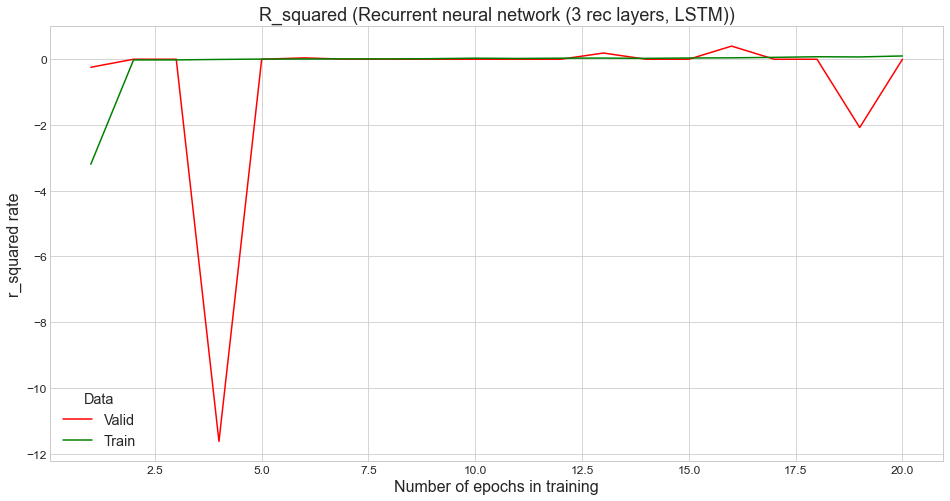

In [57]:
# Визуализируем метрики r_squared для Recurrent neural network (3 rec layers, GRU) для тренировочной и валидационной выборки
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('R_squared (Recurrent neural network (3 rec layers, LSTM))', fontsize=18)
ax1.plot(epochs_range, r_squared_list_valid_rnn3l, 'r', label = 'Valid')
ax1.plot(epochs_range, r_squared_list_train_rnn3l, 'g', label = 'Train')
ax1.set_xlabel('Number of epochs in training', fontsize=16)
ax1.set_ylabel('r_squared rate', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [58]:
# По найденному оптимальному параметру обучаем новый классификатор по Recurrent neural network (3 rec layers, LSTM)
model.fit(train_generator, steps_per_epoch=100, epochs=epochs_range[best_index],
          verbose=0, validation_data=test_generator, validation_steps=1, initial_epoch=epochs_range[best_index-1])

In [59]:
# Проверяем итоговое качество модели Recurrent neural network (3 rec layers, LSTM) на тестовых данных
samples, targets = next(test_generator)
pred = model.predict(samples)
r_squared = r2_score(y_true=targets, y_pred=pred)
mae = mean_absolute_error(y_true=targets, y_pred=pred)
r_squared_error = 'Коэффициент детерминации для решения с Recurrent neural network (3 rec layers, LSTM) - {}'\
.format(r_squared)
print(r_squared_error)
mean_abs_error = 'Средняя абсолютная ошибка для решения с Recurrent neural network (3 rec layers, LSTM) - {}'\
.format(mae)
print(mean_abs_error)

4/4 [==============================] - 0s 88ms/step
Коэффициент детерминации для решения с Recurrent neural network (3 rec layers, LSTM) - 0.4236960987520142
Средняя абсолютная ошибка для решения с Recurrent neural network (3 rec layers, LSTM) - 0.0632748226635158


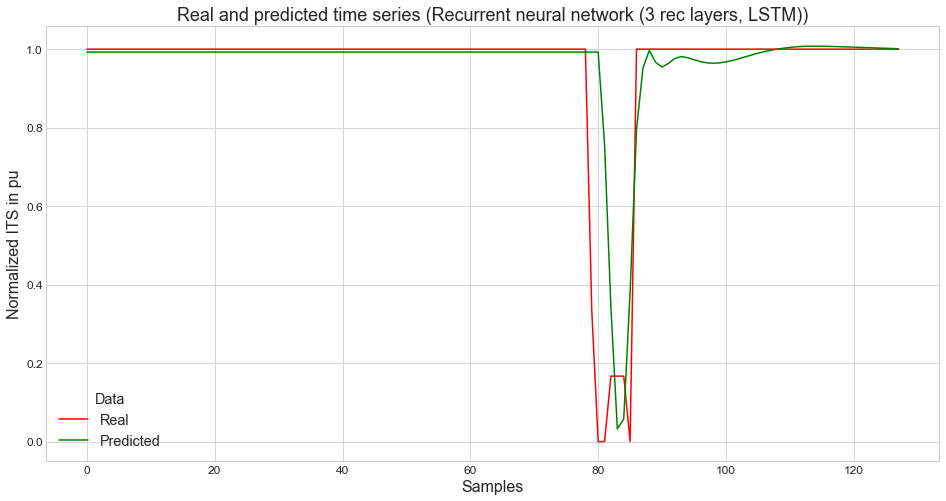

In [38]:
# Визуализируем спрогнозированного и фактического временных рядов на одном графике
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('Real and predicted time series (Recurrent neural network (3 rec layers, LSTM))', fontsize=18)
ax1.plot(samples_range, targets[0:samples.shape[0]], 'r', label = 'Real')
ax1.plot(samples_range, pred, 'g', label = 'Predicted')
ax1.set_xlabel('Samples', fontsize=16)
ax1.set_ylabel('Normalized ITS in pu', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Обучение рекуррентной сети для прогнозирования временного ряда (GRU) с тремя слоями. Расчет коэффициента детерминации и средней абсолютной ошибки. Визуализация спрогнозированных и фактических временных рядов на одном графике.

In [71]:
model = Sequential()
model.add(GRU(32, return_sequences = True, input_shape = (None, data_train_sc.shape[-1])))
model.add(GRU(32, return_sequences = True, activation = 'relu'))
model.add(GRU(32, activation = 'relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 32)          3360      
                                                                 
 gru_3 (GRU)                 (None, None, 32)          6336      
                                                                 
 gru_4 (GRU)                 (None, 32)                6336      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [72]:
EPOCHS = 20

r_squared_list_train_rnn3lg = []
r_squared_list_valid_rnn3lg = []
epochs_range = np.arange(1, EPOCHS+1, 1)
start = time.time()
model.compile(loss='mse', 
              optimizer = 'adam',
              metrics=[r2_score],
              run_eagerly=True)
history = model.fit(train_generator, steps_per_epoch=100, epochs = EPOCHS,
                    verbose = 0, validation_data = valid_generator, validation_steps=1)
# Обучаем модель Recurrent neural network (3 rec layers)
for epochs_val in epochs_range:
    r_squared_list_train_rnn3lg.append(history.history['r2_score'][epochs_val-1])
    r_squared_list_valid_rnn3lg.append(history.history['val_r2_score'][epochs_val-1])

stop = time.time()
result = 'Время работы модели Recurrent neural network (3 rec layers, GRU) - {} секунд'\
.format(stop - start)
# Сводим значения метрик в таблицу
matrix = np.matrix(np.c_[epochs_range, r_squared_list_train_rnn3lg, r_squared_list_valid_rnn3lg]) 
df_models = pd.DataFrame(data=matrix, columns=['n_epochs', 'train_r_squared', 'valid_r_squared'])
# Определяем наибольшее значение r_squared
best_r_squared = df_models['valid_r_squared'].max()
# Определяем индекс соответствующий наибольшему значению r_squared
best_index = df_models['valid_r_squared'].idxmax()
max_r_squared_rnn3lg = 'Наибольшее значение r_squared алгоритма Recurrent neural network (3 rec layers, GRU) для валидационной выборки - {}'\
.format(best_r_squared)
optimum_n_epochs = 'Оптимальное значение числа эпох для модели Recurrent neural network (3 rec layers, GRU) - {}'\
.format(epochs_range[best_index])
print(result)
print(max_r_squared_rnn3lg)
print(optimum_n_epochs)

Время работы модели Recurrent neural network (3 rec layers, GRU) - 571.6777648925781 секунд
Наибольшее значение r_squared алгоритма Recurrent neural network (3 rec layers, GRU) для валидационной выборки - 0.7826935648918152
Оптимальное значение числа эпох для модели Recurrent neural network (3 rec layers, GRU) - 16


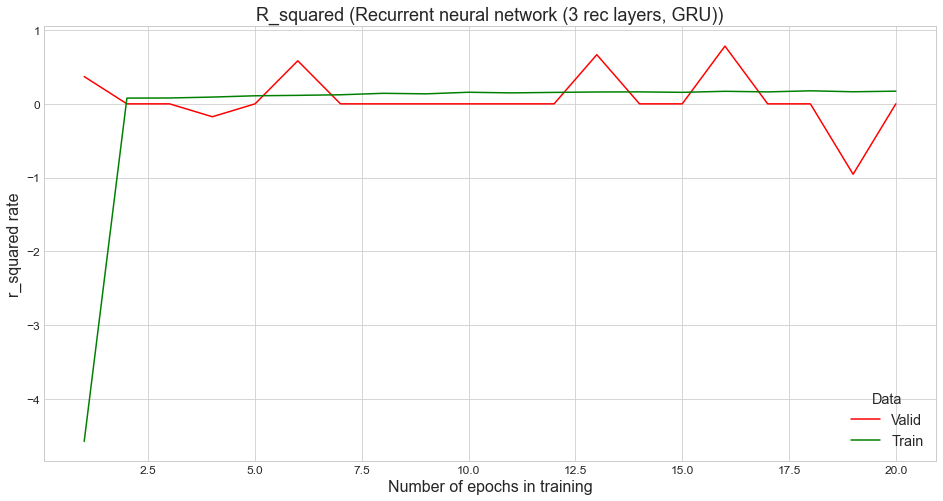

In [73]:
# Визуализируем метрики r_squared для Recurrent neural network (3 rec layers, GRU) для тренировочной и валидационной выборки
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('R_squared (Recurrent neural network (3 rec layers, GRU))', fontsize=18)
ax1.plot(epochs_range, r_squared_list_valid_rnn3lg, 'r', label = 'Valid')
ax1.plot(epochs_range, r_squared_list_train_rnn3lg, 'g', label = 'Train')
ax1.set_xlabel('Number of epochs in training', fontsize=16)
ax1.set_ylabel('r_squared rate', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [74]:
# По найденному оптимальному параметру обучаем новый классификатор по Recurrent neural network (3 rec layers, GRU)
model.fit(train_generator, steps_per_epoch=100, epochs=epochs_range[best_index],
          verbose=0, validation_data=test_generator, validation_steps=1, initial_epoch=epochs_range[best_index-1])

In [75]:
# Проверяем итоговое качество модели Recurrent neural network (3 rec layers, GRU) на тестовых данных
samples, targets = next(test_generator)
pred = model.predict(samples)
r_squared = r2_score(y_true=targets, y_pred=pred)
mae = mean_absolute_error(y_true=targets, y_pred=pred)
r_squared_error = 'Коэффициент детерминации для решения с Recurrent neural network (3 rec layers, GRU) - {}'\
.format(r_squared)
print(r_squared_error)
mean_abs_error = 'Средняя абсолютная ошибка для решения с Recurrent neural network (3 rec layers, GRU) - {}'\
.format(mae)
print(mean_abs_error)

4/4 [==============================] - 0s 110ms/step
Коэффициент детерминации для решения с Recurrent neural network (3 rec layers, GRU) - 0.6855422235319568
Средняя абсолютная ошибка для решения с Recurrent neural network (3 rec layers, GRU) - 0.039581463245364525


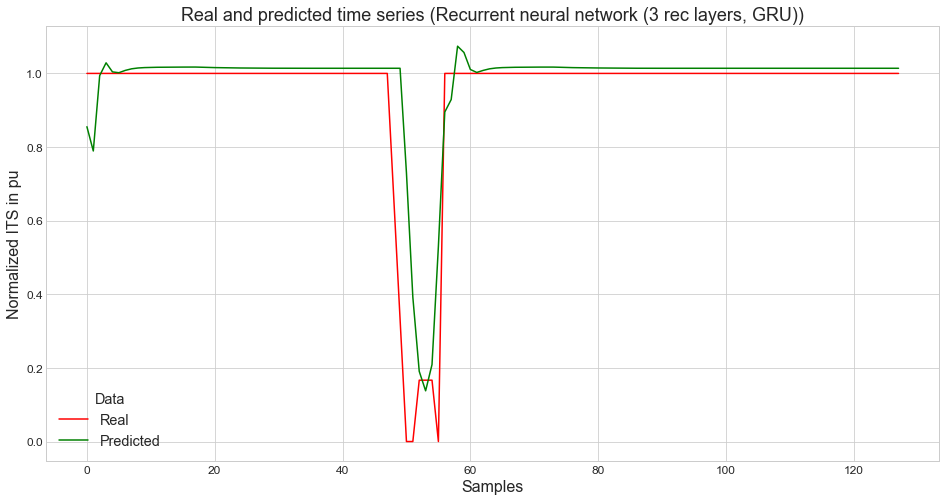

In [76]:
# Визуализируем спрогнозированного и фактического временных рядов на одном графике
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('Real and predicted time series (Recurrent neural network (3 rec layers, GRU))', fontsize=18)
ax1.plot(samples_range, targets[0:samples.shape[0]], 'r', label = 'Real')
ax1.plot(samples_range, pred, 'g', label = 'Predicted')
ax1.set_xlabel('Samples', fontsize=16)
ax1.set_ylabel('Normalized ITS in pu', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

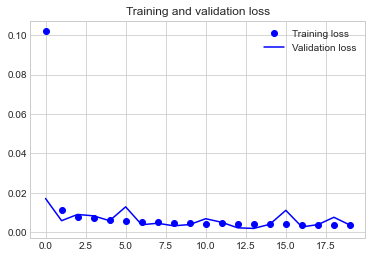

In [94]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()